In [1]:
import pandas as pd

train = pd.read_csv('./datasets/train_user.csv')
test = pd.read_csv('./datasets/test_user.csv')

In [2]:
train = train[train['label']!=2]
test = test[test['label']!=2]

In [3]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint

import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
# import emoji #pip install emoji --upgrade
# Internal dependencies
# import word_emoji2vec as we2v
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
# import torchvision.transforms as transforms
from torch.autograd import Variable

####BERT

from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# %pip install transformers==4.10.0

In [5]:
!nvidia-smi

Thu Sep  9 18:19:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 29%   46C    P0    63W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:67:00.0 Off |                  N/A |
| 31%   55C    P0    61W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
# import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
train, valid = train_test_split(train, stratify=train.label, test_size=0.2, random_state=42)

In [8]:
###### text preprocessing #########

def remove_string_noise(input_str):
    input_str = re.sub(r"http\S+", "", input_str)
    punctuation_noise ="!\"$%&'#()*+,-./:;<=>?@[\]^_`{|}~" #print string.punctuation 
    special_noise = ""

    all_noise = punctuation_noise + special_noise

    for c in all_noise:
        if c in input_str:
            input_str = input_str.replace(c, " ")#replace with space
    fresh_str = ' '.join(input_str.split())
    return fresh_str

def clean_tweets(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    operators = set(('no', 'not', 'nor', 'none'))
    stop_words = set(sw) - operators
    stop_words.update([ 'amp', 'rt'])  ###as we are using set so we used .update....otherwise .extends
    
    word_tokens = nltk.word_tokenize(tweet)
    filtered_tweet = []
    for w in word_tokens:
        #if w not in stop_words and w not in emoticons:
        if w not in stop_words:
            filtered_tweet.append(w)
    lemmatized_tweet = []
    for word in filtered_tweet:
        lemmatized_tweet.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_tweet)
    
def pre_processing_tweets (df):    
    clean_text = []

    for i in df:
        clean_text.append(p.clean(str(i)))#python 3
    fresh_text1 = []
    for i in range (0, df.shape[0]):
        fresh_text1.append(remove_string_noise(clean_text[i]))
    
    filtered_tweet = []
    for i in range (0, len(fresh_text1)):
        filtered_tweet.append(clean_tweets(fresh_text1[i].lower()))
    
    return filtered_tweet

In [9]:
sentences_train = pre_processing_tweets(train.description)
sentences_valid = pre_processing_tweets(valid.description)
sentences_test = pre_processing_tweets(test.description)

In [10]:
sentences_train = np.array(sentences_train)
labels_train = train.label.values
print(type(sentences_train))

sentences_valid = np.array(sentences_valid)
labels_valid = valid.label.values
print(type(sentences_valid))

sentences_test = np.array(sentences_test)
labels_test = test.label.values
print(type(sentences_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [12]:
input_ids_train = []
attention_masks_train = []

# For every sentence...
for sent in sentences_train:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
#The first four features are in tokenizer.encode, but I’m using tokenizer.encode_plus to get the fifth item (attention masks).

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_valid = []
attention_masks_valid = []

# For every sentence...
for sent in sentences_valid:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_valid = torch.cat(input_ids_valid, dim=0)
attention_masks_valid = torch.cat(attention_masks_valid, dim=0)
labels_valid = torch.tensor(labels_valid)

In [14]:

#The first four features are in tokenizer.encode, but I’m using tokenizer.encode_plus to get the fifth item (attention masks).

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [16]:
import torch
# torch.cuda.empty_cache() 
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    #device = torch.device("cuda") # select the zeroth GPU with this line: gpu = 0
    #device = torch.cuda.set_device(1)  #wrong provide device = None  
    device = torch.device(1) #(use cuda device 1) for gpu = 1
    torch.cuda.set_device(device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [17]:
# GPU_NUM = 1 # 원하는 GPU 번호 입력
# device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', device) # check

Current cuda device  cuda:1


In [18]:
device = torch.cuda.current_device()
device

1

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
#model.cuda() #comment it if you use cpu only
#print ('Current cuda device ', torch.cuda.current_device())
#model.to(torch.cuda.current_device())
model.to(torch.cuda.current_device())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
###Training Loop
import random
import numpy as np
from sklearn.metrics import f1_score

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# epochs = 10
losses = []
per_epoch_train_loss =[]
per_epoch_val_loss =[]
per_epoch_train_f1 =[]
per_epoch_val_f1 = []
per_epoch_train_acc = []
per_epoch_val_acc = []

# For each epoch...
for epoch_i in range(0, epochs):
    print ('Current cuda device ', device)
    torch.cuda.empty_cache() 
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = outputs.loss, outputs.logits
                
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)     
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    #torch.cuda.empty_cache(1)     
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss, logits = outputs.loss, outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    torch.cuda.empty_cache() 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Current cuda device  1

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    158.    Elapsed: 0:00:03.
  Batch    80  of    158.    Elapsed: 0:00:07.
  Batch   120  of    158.    Elapsed: 0:00:10.

  Average training loss: 0.73
  Training epcoh took: 0:00:14

Running Validation...
 Validation Accuracy: 0.53
  Validation Loss: 0.71
  Validation took: 0:00:01
Current cuda device  1

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    158.    Elapsed: 0:00:03.
  Batch    80  of    158.    Elapsed: 0:00:07.
  Batch   120  of    158.    Elapsed: 0:00:10.

  Average training loss: 0.68
  Training epcoh took: 0:00:14

Running Validation...
 Validation Accuracy: 0.55
  Validation Loss: 0.73
  Validation took: 0:00:01
Current cuda device  1

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    158.    Elapsed: 0:00:03.
  Batch    80  of    158.    Elapsed: 0:00:07.
  Batch   120  of    158.    Elapsed: 0:00:11.

  Average training loss: 0.55
  Training epcoh to

In [27]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.73,0.71,0.53,0:00:14,0:00:01
2,0.68,0.73,0.55,0:00:14,0:00:01
3,0.55,0.76,0.58,0:00:14,0:00:01
4,0.35,1.23,0.55,0:00:14,0:00:01
5,0.27,1.48,0.56,0:00:15,0:00:01
6,0.23,1.79,0.53,0:00:15,0:00:01
7,0.21,1.89,0.54,0:00:15,0:00:01
8,0.20,2.00,0.53,0:00:15,0:00:01
9,0.21,2.00,0.57,0:00:15,0:00:01


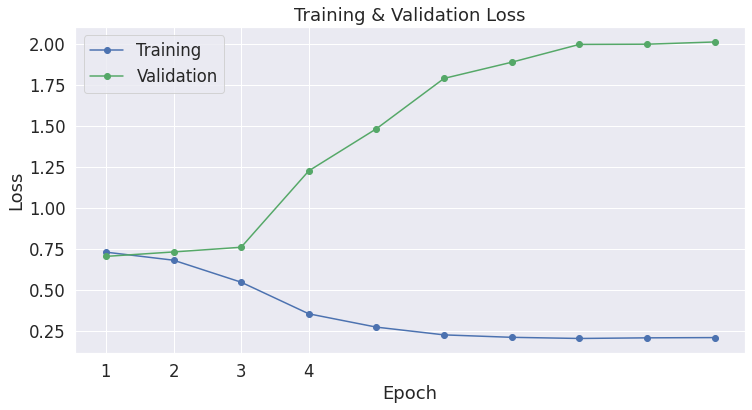

<Figure size 864x432 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

plt.savefig('./img/bert_user_description_train_valid_loss.pdf')

In [29]:
# %pip install seaborn

In [30]:
# For Test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [31]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 396 test sentences...
    DONE.


In [32]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


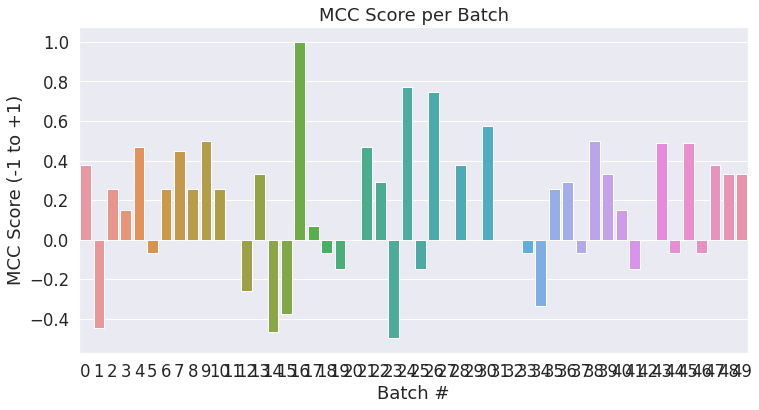

In [33]:
import seaborn as sns

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [34]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.120


In [35]:
print(type(flat_true_labels), len(flat_true_labels), len(test_dataloader))

<class 'numpy.ndarray'> 396 50


In [36]:
accuracy = np.sum(np.array(flat_true_labels) == np.array(flat_predictions)) /len(flat_true_labels)
print("accuracy", accuracy)

accuracy 0.5580808080808081


In [37]:
from sklearn.metrics import classification_report

print(classification_report(flat_true_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.5472    0.6985    0.6137       199
           1     0.5775    0.4162    0.4838       197

    accuracy                         0.5581       396
   macro avg     0.5624    0.5574    0.5487       396
weighted avg     0.5623    0.5581    0.5491       396

